# Loading Necessary Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import catboost as cb
from torchvision import transforms
from PIL import Image
import shap

# Load the OASIS-1 dataset
df = pd.read_excel("oasis_cross-sectional.xlsx")

# OASIS-1 Information: Shape, Missing Values, and Duplicates

In [2]:
# Display basic information for OASIS-1
print("OASIS-1 Data Shape:", df.shape)
display(df.head())
display(df.info())

# Check for missing values in OASIS-1
missing_values1 = df.isnull().sum()
print("OASIS-1 Missing Values:\n", missing_values1[missing_values1 > 0])

# Check for duplicates in OASIS-1
duplicates1 = df.duplicated().sum()
print("OASIS-1 Number of duplicate rows:", duplicates1)

OASIS-1 Data Shape: (436, 12)


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


None

OASIS-1 Missing Values:
 Educ     201
SES      220
MMSE     201
CDR      201
Delay    416
dtype: int64
OASIS-1 Number of duplicate rows: 0


As can be seen above, for Oasis-1, there is a large amount of missing values for Educ, SES, MMSE, CDR, and Delay. The datatype used is int64 for Age and eTIV, float64 for Educ, SES, MMSE, CDR, nWBV, ASF, and Delay, while ID, M/F, and Hand are objects. The shape is (436, 12) and there are no duplicate rows. Overall, there are 436 different entries for 12 different attributes.

# Oasis-1 Class Distribution

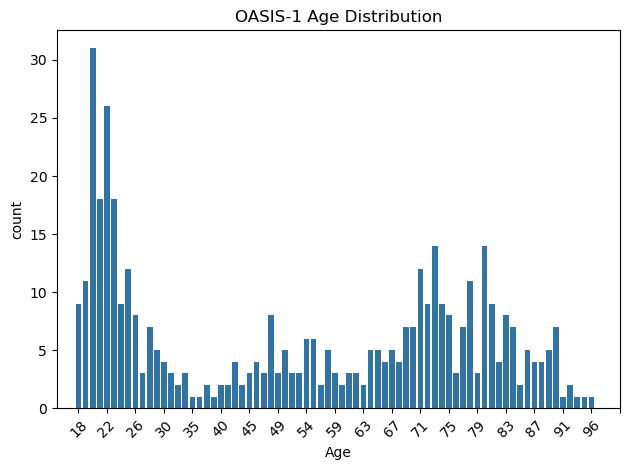

In [3]:

# Age distribution in OASIS-1
class_column1 = df.columns[3]
sns.countplot(x=class_column1, data=df)
plt.title("OASIS-1 Age Distribution")

# Set x-axis limits and ticks from 20 to 100
plt.xlim(-3, 10)
plt.xticks(ticks=range(0, 77, 4), rotation=45)

plt.tight_layout()
plt.show()


# Class Distribution

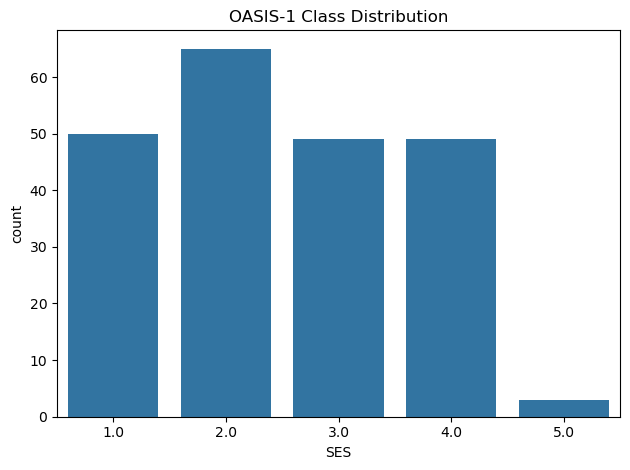

In [4]:
# Age distribution in OASIS-1
class_column1 = df.columns[5]
sns.countplot(x=class_column1, data=df)
plt.title("OASIS-1 Class Distribution")

plt.tight_layout()
plt.show()

# OASIS-1 Summary Statistics and Histogram

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


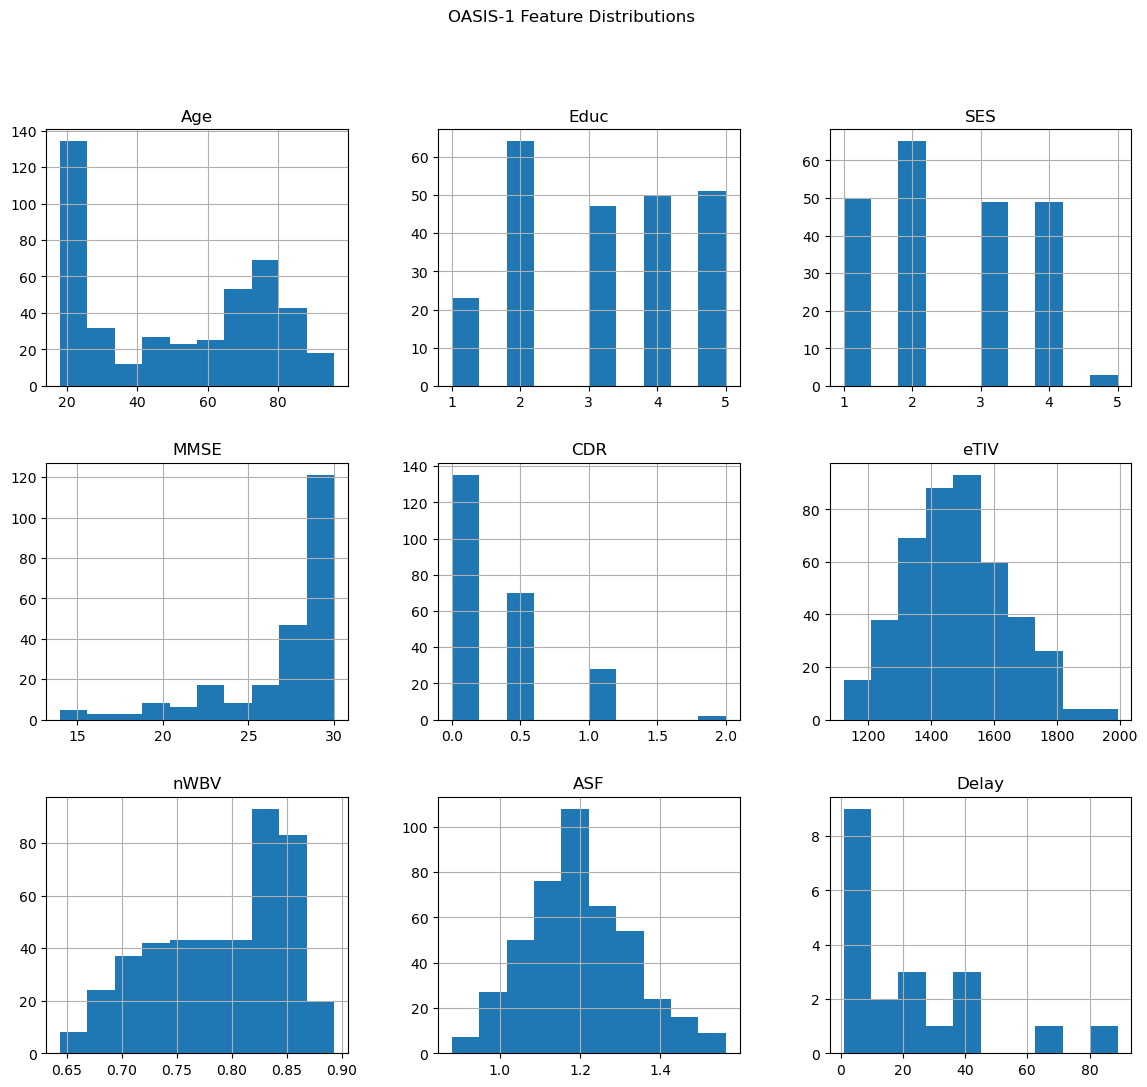

In [5]:
# Display summary statistics for OASIS-1
display(df.describe())

# Histograms for numerical features in OASIS-1
df.hist(figsize=(14, 12))
plt.suptitle("OASIS-1 Feature Distributions")
plt.show()


Naturally, due to the nature of the different attributes, there are different values for each. The attributes that are objects are not included due to this. For those represented, a lot of trends can be gleaned. A staggering number of participants are young, but a good amount of older folks were tested too, explaining the mean of 51 and standard deviation of 25. Education is by education level, but this is incomplete and much harder to analyze. For the most part, the socioeconomic statuses are equal, which a minority being the richest. The MMSE is the mini-mental state examination, with the large number of 30s being expected, as this is a perfect score and thus shows someone who retains their mental acuity. The lower scores show those that are potentially demented. Accordingly, the CDR is the clinical dementia rating, with the rating mostly showing people with zeroes, which implies no dementia. The higher scores show those rated to be demented. ASF, nWBV, and eTIV are all attributes describing the brain volume, which can be supposed to measure atrophy in outliers. Accordingly, eTIV and ASF are mostly uniform, while nWBV is skewed towards the higher end, while still having many values 0.644 and above. The delay being practically nonexistent makes sense, as this is how much a person delayed since the last visit. If most people are irrelevant to this, then this will not be included for them.

# Oasis-1 Boxplots and Correlation Matrix

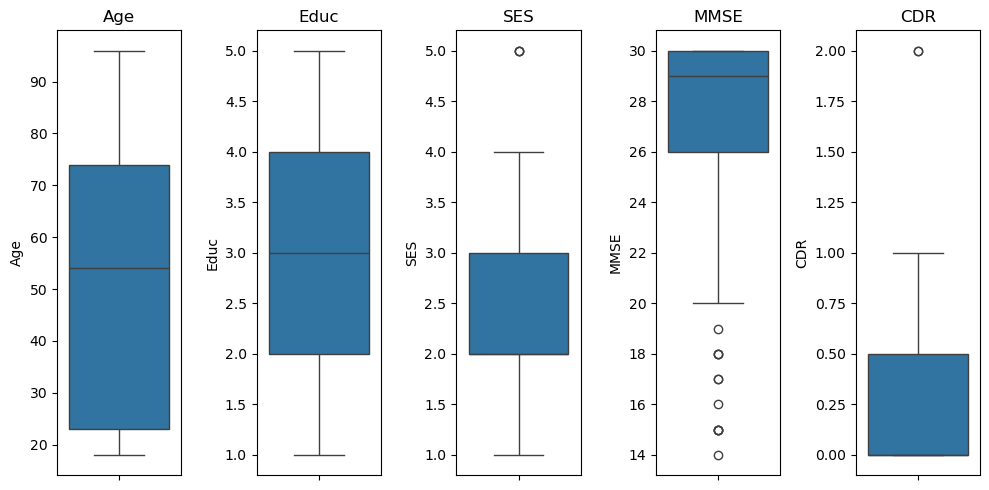

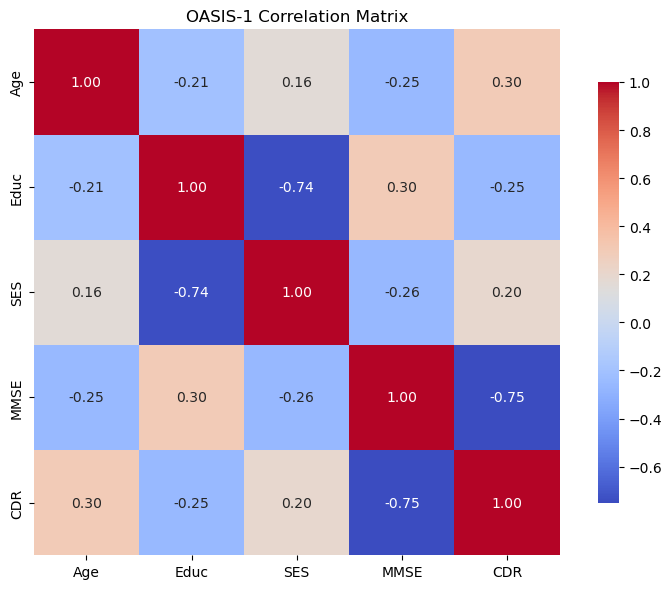

In [6]:
# Boxplots and subplots for features in OASIS-1
plt.figure(figsize=(10, 5))
num_cols1 = df.select_dtypes(include=np.number).columns
num_cols1 = num_cols1.dropna()  # Drop any NaN columns if they exist
num_cols1 = num_cols1[num_cols1 != 'age']  # Exclude 'age' if it's not needed
num_cols1 = num_cols1[:5]  # Limit to first 8 numerical columns for clarity
for i, col in enumerate(num_cols1):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

# Check for correlations in OASIS-1
correlation_matrix1 = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(8, 6))
# Limit the correlation matrix to the first 5 numerical columns for clarity
correlation_matrix1 = correlation_matrix1.iloc[:5, :5]  # Limit to first 5 numerical columns
sns.heatmap(correlation_matrix1, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("OASIS-1 Correlation Matrix")
plt.tight_layout()
plt.show()



# Loading In Images

Image Categories: ['Mild Dementia', '.DS_Store', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
Image Data Shape: (86437, 2)


,image_path,label
0,Data/Mild Dementia/OAS1_0137_MR1_mpr-3_139.jpg,Mild Dementia
1,Data/Mild Dementia/OAS1_0291_MR1_mpr-3_109.jpg,Mild Dementia
2,Data/Mild Dementia/OAS1_0278_MR1_mpr-2_110.jpg,Mild Dementia
3,Data/Mild Dementia/OAS1_0382_MR1_mpr-4_123.jpg,Mild Dementia
4,Data/Mild Dementia/OAS1_0316_MR1_mpr-1_147.jpg,Mild Dementia


Image Data Missing Values:
 Series([], dtype: int64)
Image Data Number of duplicate rows: 0


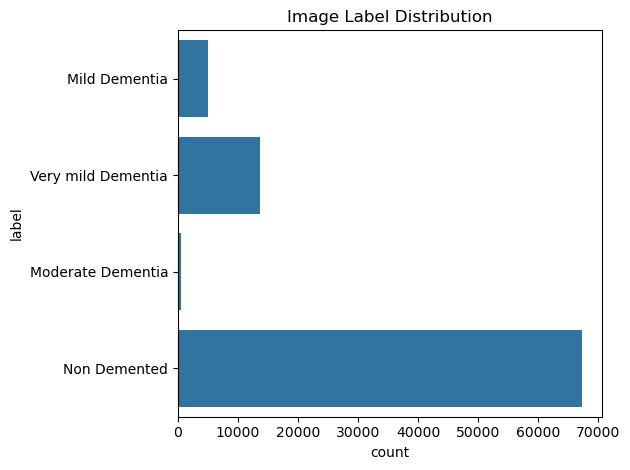

In [7]:
# From the Data folder, get all the images
image_folder = "Data"
folder_categories = os.listdir(image_folder)
# Display the folder categories
print("Image Categories:", folder_categories)
# Load images and labels into a DataFrame
image_data = []
for category in folder_categories:
    category_path = os.path.join(image_folder, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_data.append({
                    "image_path": os.path.join(category_path, filename),
                    "label": category
                })
                
# Convert to DataFrame
image_df = pd.DataFrame(image_data)

# Display the first few rows of the image DataFrame
print("Image Data Shape:", image_df.shape)
display(image_df.head())

# Check for missing values in image DataFrame
missing_values_images = image_df.isnull().sum()
print("Image Data Missing Values:\n", missing_values_images[missing_values_images > 0])

# Check for duplicates in image DataFrame
duplicates_images = image_df.duplicated().sum()
print("Image Data Number of duplicate rows:", duplicates_images)

# Display the distribution of image labels
sns.countplot(y='label', data=image_df)
plt.title("Image Label Distribution")
plt.tight_layout()
plt.show()

# Define Transformations


In [8]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB
        image = transform(image)  # Apply transformations
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Preprocess the images
**PLEASE PLEASE PLEASE**
DONT FORGET TO CHANGE THE FRACTION OF HOW MUCH THE DATABASE IS USED, ITS 1% FOR BASIC TESTING ON MACBOOKS

In [9]:
# Take 5% of the image data for training
image_df = image_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
# Display the shape of the sampled image DataFrame
print("Sampled Image Data Shape:", image_df.shape)

# Load and preprocess all images
images = []
labels = []

for index, row in image_df.iterrows():
    image_path = row['image_path']
    label = row['label']
    image_tensor = load_and_preprocess_image(image_path)
    if image_tensor is not None:
        images.append(image_tensor)
        labels.append(label)
# Convert lists to tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(pd.factorize(labels)[0])  # Factorize labels to numeric values

# Create a TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)
# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Sampled Image Data Shape: (864, 2)


/var/folders/fq/1q3gpj4s5pv3d5hhbdgzm0gh0000gn/T/ipykernel_32193/1546903112.py:19: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels_tensor = torch.tensor(pd.factorize(labels)[0])  # Factorize labels to numeric values


# Define the CNN Portion

In [10]:
class MRICNN(nn.Module):
    # Define the model architecture
    def __init__(self, num_classes):
        super(MRICNN, self).__init__()
        # Load a pre-trained ResNet model
        self.base_model = models.resnet18(pretrained=True)
        # Modify the final layer to use CatBoost for classification
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    # Define the forward pass
    def forward(self, x):
        x = self.base_model(x)
        return x


# Define Training Process
Compare the patient IDs with those in the clincial data, where higher CDR scores correleate to higher dementia.

In [11]:
# Initialize the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(image_df['label'].unique())
model = MRICNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the training process
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        print (f"Epoch {epoch+1}/{num_epochs}")
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Loss: {epoch_loss:.4f}")



# Evaluate the model on the training set
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Model Accuracy: {accuracy:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train and Evaluate the Model

Train the model based on a few epochs and the training set

In [12]:
# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=5)

# Evaluate the model on the training set
evaluate_model(model, dataloader)

Epoch 1/5


KeyboardInterrupt: 

# Train CatBoost